# Интро

Целью данного проекта является построение модели нейронной сети, которая способна отличать одно изображение от другого в условиях неподготовленных данных. То есть, данные для работы модели нужно искать самостоятельно.


Для этого будет использоваться Google и расширение для Download All Images 


Тема классификатора: отличить веселых людей от грустных.

# Установка нужного окружения

In [1]:
import tensorflow as tf
import os

In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.99)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

# Избавление от неподходящих изображений

В данном блоке мы будем избавляться от от изображений, которые не подходят по критериям

Мы взяли первые попавшиеся изображения по тегу happy people и sad people. Избавились от изображений, которые весят меньше 10 кб.

In [3]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [4]:
data_dir = 'data' #путь для данных

In [5]:
image_exts = ['jpeg','jpg', 'bmp', 'png'] #

In [6]:
for image_class in os.listdir(data_dir): #для обеих папок в директории с данными
    for image in os.listdir(os.path.join(data_dir, image_class)): #для каждого изображения в папке
        image_path = os.path.join(data_dir, image_class, image) #берем каждое изображение
        try: 
            img = cv2.imread(image_path) #opencv открывает изображение как np.array
            tip = imghdr.what(image_path) #показывает тип изображения
            if tip not in image_exts: #если тип изображения не один из списка
                print('Image not in ext list {}'.format(image_path)) #изображения не листе
                os.remove(image_path) #удаляет изображение
        except Exception as e: #если какая-то другая ошибка с чтением изображения
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Загрузка данных

Для загрузки будем использовать пайплайн

In [7]:
import numpy as np

In [8]:
data = tf.keras.utils.image_dataset_from_directory('data', batch_size=16)  #функция создает датасет из изображений в директории
#это оооочень удобная функция, т.к. она выполняет много работы в одной строке (деление на батчи, шафл, ресайз)

Found 208 files belonging to 2 classes.


In [9]:
##tf.keras.utils.image_dataset_from_directory??
##позволяет узнать как функция настроила датасет

In [10]:
#Однако, если мы захотим посмотреть на data, то это будет не так просто, т.к. мы имеем сгенерированный датасет разделенный на
#батчи. Чтобы посмотреть на датасет можно создать итератор, который будет проходить через каждый батч
data_iterator = data.as_numpy_iterator() 

In [11]:
batch = data_iterator.next() #здесь получаем доступ к батчу

In [12]:
len(batch)
#2 в ответе на команду len означает, что batch содержит два листа: лист в признаками и с лейблами.

2

In [13]:
batch[0].shape
# 32 - размер батча, 256 * 256 - размер изображения, 3 - кол-во цветов

(16, 256, 256, 3)

In [14]:
batch[1] #здесь хранятся лейблы

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0])

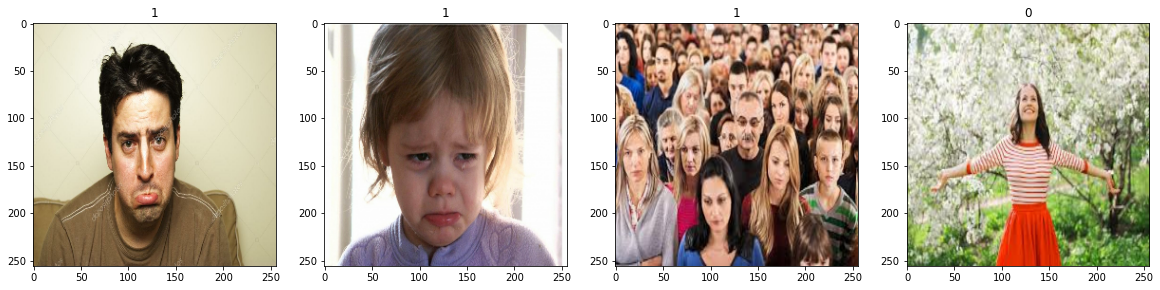

In [15]:
#способ визуализации изображения с лейблами
#тЭто также один из способов узнать какой класс является 0, а какой 1
#1 - грустные люди, 0 - радостные
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Предподготовка данных

In [16]:
#для работы с нейросетью луччше подходят маленькие значение. Так веса не будут становится слишком большми
# мы не можем просто data[0] / 255, т.к. датасет состоит из батчей. Поэтому:
data = data.map(lambda x,y: (x/255, y))

In [17]:
scaled_iterator = data.as_numpy_iterator()

In [18]:
batch = scaled_iterator.next()

In [19]:
batch[0].max()

1.0

# Разделение данных

In [20]:
#всего у нас батчей:
len(data)

13

In [21]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [22]:
train = data.take(train_size) #в аргументах указывается сколько батчей мы хотим take - взять, skip - пропустить
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Построение модели

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [24]:
model = Sequential()

In [25]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# Обучение

In [28]:
logdir='logs'

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [30]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
9/9 [==============================] - 14s 395ms/step - loss: 0.8853 - accuracy: 0.4861 - val_loss: 0.6680 - val_accuracy: 0.6667
Epoch 2/20
9/9 [==============================] - 4s 312ms/step - loss: 0.6369 - accuracy: 0.6389 - val_loss: 0.5720 - val_accuracy: 0.7500
Epoch 3/20
9/9 [==============================] - 3s 289ms/step - loss: 0.6012 - accuracy: 0.6667 - val_loss: 0.4625 - val_accuracy: 0.8542
Epoch 4/20
9/9 [==============================] - 3s 300ms/step - loss: 0.5865 - accuracy: 0.7083 - val_loss: 0.4762 - val_accuracy: 0.8333
Epoch 5/20
9/9 [==============================] - 3s 293ms/step - loss: 0.4245 - accuracy: 0.8472 - val_loss: 0.2715 - val_accuracy: 0.9167
Epoch 6/20
9/9 [==============================] - 3s 294ms/step - loss: 0.2956 - accuracy: 0.8958 - val_loss: 0.2205 - val_accuracy: 0.9375
Epoch 7/20
9/9 [==============================] - 3s 288ms/step - loss: 0.1648 - accuracy: 0.9583 - val_loss: 0.1084 - val_accuracy: 0.9375
Epoch 8/20
9/9 [===

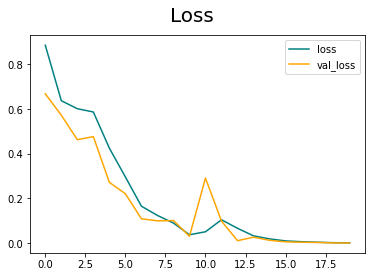

In [38]:
#построим график обучения, чтобы не вызывать tensorboard

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

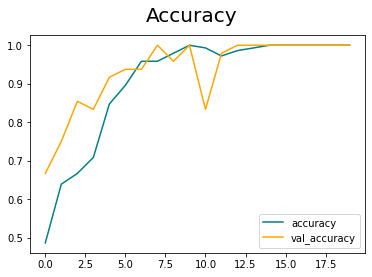

In [36]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

# Оценка модели

In [33]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [34]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [39]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 173ms/step


In [43]:
print(f'Precision: {pre.result()}, Recall: {re.result()}, Accuracy: {acc.result()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


# Тест

Посмотрим как модель покажет себя на рандомном изображении из интернета

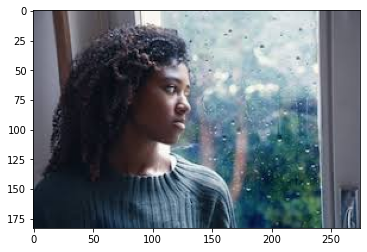

In [62]:
#читаем изображение
img = cv2.imread('sadtest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

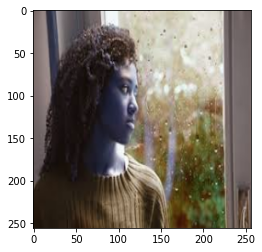

In [63]:
#изменяем размер
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [64]:
yhat = model.predict(np.expand_dims(resize/255, 0))
#np.expand_dims нужен из-за того, что нейронная сеть ожидает, что на вход поступит батч, а не одно изображение
#таким образом мы добавляем дополнительное измерение (в доп array) внутри которого бы оказался наш единственный сэмпл, 
#если бы он был внутри батча. Пример снизу

1/1 [==============================] - 0s 24ms/step


In [65]:
resize.shape

TensorShape([256, 256, 3])

In [66]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [67]:
yhat
#happy - 0
#sad - 1 

array([[0.9984553]], dtype=float32)

In [68]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# Сохраняем модель

In [69]:
from tensorflow.keras.models import load_model

In [70]:
#создаем новую папку и создаем внутри нее модель
model.save(os.path.join('models','imageclassifier.h5'))

In [76]:
#загружаем модель
new_model = load_model(os.path.join('models', 'imageclassifier.h5'))

In [77]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 112ms/step


array([[0.9984553]], dtype=float32)